In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sbn
import pandas as pd
import numpy as np
from galaxyteam.models.cnn import create_dataset
from galaxyteam.metrics import F1_Score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix
from skimage.io import imread
from tensorflow.keras.models import load_model

2022-06-03 14:09:57.177280: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Model Selection

## Reading the Models In

We need to read in all of our best-fit models and compare their performance on the validation set.  In the case of the k-nearest neighbors model, it is simple enough (and non-trivial to store), so we simply quickly retrain it here with the correct parameters

### k-Nearest Neighbors

In [2]:
train_info_file_path = Path('data').joinpath('preprocessed',
                                             'train_metadata.csv')
test_info_file_path = Path('data').joinpath('preprocessed',
                                             'test_metadata.csv')

full_train = pd.read_csv(train_info_file_path)
test_data = pd.read_csv(test_info_file_path)
train_data, val_data = train_test_split(full_train, test_size=0.2,
                                        shuffle=True,
                                        stratify=full_train.is_pneumonia,
                                        random_state=9473)

In [3]:
# Reading in k-NN data
X_train = [imread(path,as_gray=True) for path in train_data.resized_file_path]
y_train = np.array([pnu for pnu in train_data.is_pneumonia])
X_val = [imread(path,as_gray=True) for path in val_data.resized_file_path]
y_val = np.array([pnu for pnu in val_data.is_pneumonia])
X_test = [imread(path,as_gray=True) for path in test_data.resized_file_path]
y_test = np.array([pnu for pnu in test_data.is_pneumonia])

X_train = np.reshape(X_train, (np.shape(X_train)[0], -1))
X_test = np.reshape(X_test, (np.shape(X_test)[0], -1))
X_val = np.reshape(X_val, (np.shape(X_val)[0], -1))

knn_model = KNeighborsClassifier(n_neighbors=18)
knn_model.fit(X_train, y_train);

### Convolutional Neural Networks

In [4]:
# Read in CNNs

train_dataset = create_dataset(train_data.resized_file_path,
                               train_data.is_pneumonia,
                               batch_size=128)
val_dataset = create_dataset(val_data.resized_file_path,
                             val_data.is_pneumonia,
                             batch_size=128)

cnn_model = load_model('CNN_v1', custom_objects={'F1_Score':F1_Score})
# tl_model = load_model('TL_v2')

2022-06-03 14:10:06.196524: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-03 14:10:06.197473: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-03 14:10:06.197865: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-03 14:10:06.197878: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (XPS-15): /proc/driver/nvidia/version does not exist
2022-06-03 14:10:06.198833: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022

## Making Predictions and Evaluating Performance

In [5]:
knn_pred = knn_model.predict(X_val)
knn_conf_mat = confusion_matrix(y_val, knn_pred)
knn_f1 = f1_score(y_val, knn_pred)

In [6]:
cnn_pred = cnn_model.predict(val_dataset).squeeze()>=0.5
cnn_conf_mat = confusion_matrix(y_val, cnn_pred)
cnn_f1 = f1_score(y_val, cnn_pred)

2022-06-03 14:10:10.817035: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-03 14:10:10.836638: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz
2022-06-03 14:10:10.916184: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1614938112 exceeds 10% of free system memory.
2022-06-03 14:10:11.438411: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1614938112 exceeds 10% of free system memory.
2022-06-03 14:10:11.933625: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1614938112 exceeds 10% of free system memory.
2022-06-03 14:10:12.453501: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1614938112 exceeds 10% of free system memory.
2022-06-03 14:10:12.992976: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1614938112 exceeds 10% of free system memory.


In [7]:
# tl_pred = tl_model.predict(val_dataset).squeeze()>0.5
# tl_conf_mat = confusion_matrix(y_val, tl_pred)
# tl_f1 = f1_score(y_val, tl_pred)

Text(0.5, 11.0, 'True')

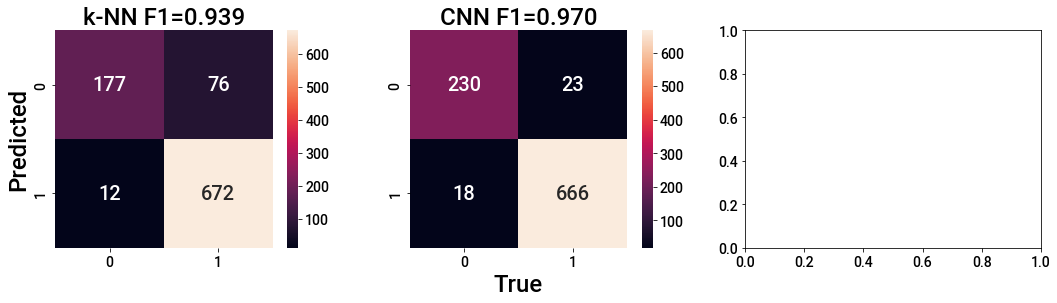

In [8]:
fig = plt.figure(figsize=(18, 4))
knn_sp = fig.add_subplot(131)
cnn_sp = fig.add_subplot(132)
tl_sp = fig.add_subplot(133)

sbn.heatmap(knn_conf_mat, ax=knn_sp, annot=True, 
            square=True, fmt='d', 
            annot_kws=dict(fontsize=20))
sbn.heatmap(cnn_conf_mat, ax=cnn_sp, annot=True,
            square=True, fmt='d',
            annot_kws=dict(fontsize=20))
# sbn.heatmap(tl_conf_mat, ax=tl_sp, annot=True,
#             square=True, fmt='d',
#             annot_kws=dict(fontsize=20))

knn_sp.set_title(f'k-NN F1={knn_f1:.3f}')
knn_sp.set_ylabel('Predicted')

cnn_sp.set_title(f'CNN F1={cnn_f1:.3f}')
cnn_sp.set_xlabel('True')

# knn_sp.set_title(f'TL F1={tl_f1:.3f}')

# How well does our CNN do on the Test set?

In [9]:
test_dataset = create_dataset(test_data.resized_file_path,
                              test_data.is_pneumonia,
                              batch_size=128)

cnn_test_pred = cnn_model.predict(test_dataset).squeeze()>=0.5
cnn_test_conf_mat = confusion_matrix(y_test, cnn_test_pred)
cnn_test_f1 = f1_score(y_test, cnn_test_pred)

Text(0.5, 1.0, 'Test F1=0.964')

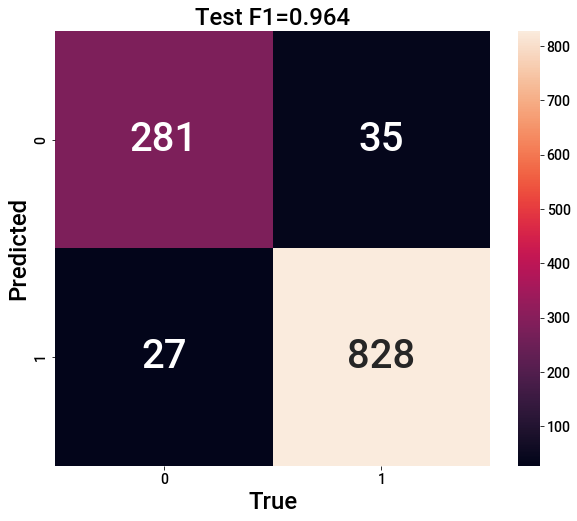

In [10]:
fig = plt.figure(figsize = (10, 8))
sp = fig.add_subplot(111)

sbn.heatmap(cnn_test_conf_mat, ax=sp,
            annot=True, square=True, fmt='d',
            annot_kws=dict(fontsize=40))
sp.set_xlabel('True')
sp.set_ylabel('Predicted')
sp.set_title(f'Test F1={cnn_test_f1:.3f}')

## Conclusions

In conclusion, we find that a custom-trained convolutional neural network represents a substantive improvement over the other two models by decreasing the margin between the F1 score and its maximum possible value of 1. 